In [ ]:
# Svelvik CO₂ Seismic Monitoring Analysis
This project analyses SEG-2 seismic data from the Svelvik CO₂ Field Lab to detect and interpret changes in the subsurface caused by CO₂ plume migration.

Using Python-based workflows, we inspect, clean, and compare seismic signals from:
    - Baseline data (pre-injection)
    - Injection data
    - Post-injection data

The focus is on detecting changes in waveform shape, amplitude, and arrival time using:
    - ObsPy: for SEG-2 file handling, filtering, and signal processing
    - Matplotlib: for waveform visualisation
    - Simulated geometry: to compare traces across a synthetic receiver layout


# Workflow:
📂 Files → 🔍 Inspect → 🧹 Clean + Filter → 📊 Compare (Baseline vs Injection) → 🧠 Interpret Plume Effects

This notebook is structured to guide interpretation through signal analysis, leading toward potential plume zone localisation in the subsurface.
                             

In [ ]:
# 1: Import Required Libraries

# We begin by importing the necessary libraries for loading and visualizing SEG-2 seismic files using ObsPy and Matplotlib.


In [1]:
pip install obspy

In [3]:
from obspy import read
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="obspy.io.seg2.seg2")

In [ ]:
# 2: Sample One SEG-2 File per Monitoring Phase

Before processing, we sample one file from each dataset (Baseline, Injection, Post-Injection)  
to check the available metadata, waveform quality, and ensure consistent structure.

This helps us determine:
    - Which fields (e.g. `RECEIVER_STATION_NUMBER`) are usable
    - Whether location info (GPS) is available
    - Whether each trace contains valid amplitude data


In [5]:
baseline = read(r"C:\Users\Joy\Downloads\svelvik\data\Baseline_data_2019\rec0382.sg2")
injection = read(r"C:\Users\Joy\Downloads\svelvik\data\CO2_injection_data_2019\rec0982.sg2")
post = read(r"C:\Users\Joy\Downloads\svelvik\data\Post_Injection_data_2019\rec1346.sg2")

print("Baseline:")
print(baseline[0].stats)
print(baseline[0].stats.seg2)

print("\nInjection:")
print(injection[0].stats)
print(injection[0].stats.seg2)

print("\nPost-Injection:")
print(post[0].stats)
print(post[0].stats.seg2)


Baseline:
         network: 
         station: 
        location: 
         channel: 
       starttime: 2019-08-08T18:01:36.000000Z
         endtime: 2019-08-08T18:01:36.127969Z
   sampling_rate: 32000.0
           delta: 3.125e-05
            npts: 4096
           calib: 1.0
         _format: SEG2
            seg2: AttribDict({'ACQUISITION_DATE': '08/AUG/2019', 'ACQUISITION_TIME': '18:01:36', 'INSTRUMENT': 'DMT SUMMIT', 'TRACE_SORT': 'AS_ACQUIRED', 'UNITS': 'CENTIMETERS', 'ALIAS_FILTER': '16000 0', 'AMPLITUDE_RECOVERY': 'NONE', 'CHANNEL_NUMBER': '1', 'DELAY': '-0.0015625', 'FIXED_GAIN': '0', 'HIGH_CUT_FILTER': '7200 6', 'LOW_CUT_FILTER': '1 0', 'RAW_RECORD': '382', 'RECEIVER_COMPONENT': '2', 'RECEIVER_LINE_NUMBER': '1', 'RECEIVER_LOCATION': '0, 0, 0', 'RECEIVER_STATION_NUMBER': '1', 'RU_ADDRESS_NUMBER': '113 131', 'SAMPLE_INTERVAL': '0.00003125', 'SERIAL_PORT_NUMBER': '1082', 'SHOT_SEQUENCE_NUMBER': '382', 'SOURCE_LINE_NUMBER': '1', 'SOURCE_STATION_NUMBER': '1', 'STACK': '4', 'SURVEY'

In [ ]:
#  3: Inspect a Single Trace (Baseline Phase)

Before scaling up to compare multiple time-lapse datasets, we inspect a sample trace from the baseline dataset.

This helps us:
    - Assess signal quality and detect potential noise
    - Confirm trace length and sampling rate
    - Visualize general waveform characteristics (e.g., arrival windows, reflections)

This trace serves as a baseline reference for comparison with later injection and post-injection phases.


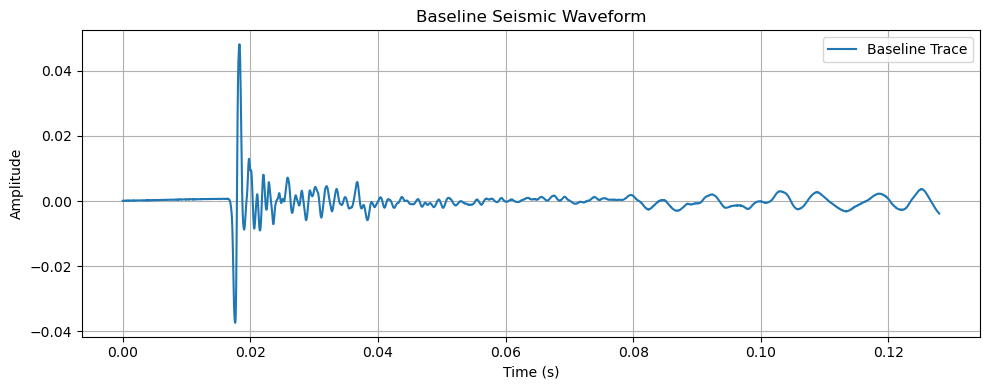

In [7]:
trace = baseline[0]

plt.figure(figsize=(10, 4))
plt.plot(trace.times(), trace.data, label="Baseline Trace") 
plt.title("Baseline Seismic Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True) # False..without grid
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#  4: Load and Clean Full Dataset

We now scale up from inspecting individual traces to preparing the full SEG-2 datasets from each phase (baseline, injection, and post-injection) for analysis. 
This includes loading, filtering, and preprocessing traces to ensure waveform comparability across all monitoring stages.

# Key Processing Steps:
    - 4.1 clean_stream(): Loads SEG-2 files and filters out flat (zero-amplitude) traces
    - 4.2 Visual Check (Before Filtering): Plots 1 sample cleaned trace per phase for quality control
    - 4.3 process_trace():  Applies a bandpass filter and normalises amplitudes
    - 4.4 Visual Check (After Filtering): Confirms signal clarity and readiness for further analysis
    - 4.5 Comparison – Before vs After Filtering
                                                                                    

In [9]:
#  4.1: Define clean_stream() to load + filter out flat traces

import os

def clean_stream(folder_path):
    """
    Reads and cleans SEG-2 files from a folder.
    Filters out traces with flat amplitude (constant or zero values).
    """
    all_files = glob.glob(os.path.join(folder_path, "*.sg2"))  # Adjust extension if needed
    stream = []
    for f in all_files:
        try:
            traces = read(f)
            for tr in traces:
                if not np.allclose(tr.data, tr.data[0]):  # Exclude flat traces
                    stream.append(tr)
        except Exception as e:
            print(f"Error reading {f}: {e}")
    return stream
    

In [11]:
baseline_folder = r"C:\Users\joy\Downloads\svelvik\data\Baseline_data_2019"
injection_folder = r"C:\Users\joy\Downloads\svelvik\data\CO2_injection_data_2019"
post_folder = r"C:\Users\joy\Downloads\svelvik\data\Post_injection_data_2019"

baseline_clean = clean_stream(baseline_folder)
injection_clean = clean_stream(injection_folder)
post_clean = clean_stream(post_folder)

print(f"Baseline traces loaded: {len(baseline_clean)}")
print(f"Injection traces loaded: {len(injection_clean)}")
print(f"Post-Injection traces loaded: {len(post_clean)}")


Baseline traces loaded: 26352
Injection traces loaded: 26070
Post-Injection traces loaded: 25736


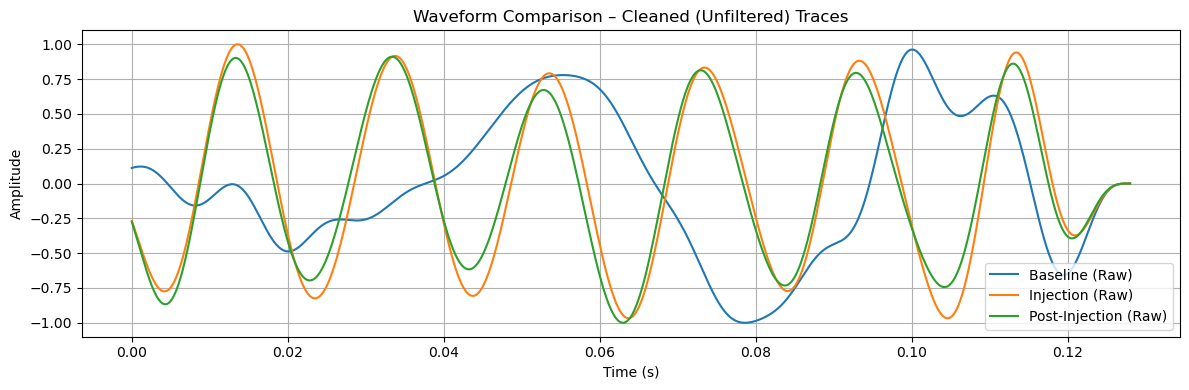

In [21]:
#  4.2: Plot a Cleaned Trace from Each Phase (Before Filtering)
# This helps you check signal quality and see the raw waveform state before applying filters

plt.figure(figsize=(12, 4))
plt.plot(baseline_clean[0].times(), baseline_clean[0].data, label="Baseline (Raw)")
plt.plot(injection_clean[0].times(), injection_clean[0].data, label="Injection (Raw)")
plt.plot(post_clean[0].times(), post_clean[0].data, label="Post-Injection (Raw)")

plt.title("Waveform Comparison – Cleaned (Unfiltered) Traces")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# 4.3: Define process_trace() to apply a bandpass filter and normalise amplitude

def process_trace(tr, freqmin=10, freqmax=100):
    tr.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    tr.data = tr.data / np.max(np.abs(tr.data))
    return tr


In [17]:
baseline_clean = [process_trace(tr) for tr in baseline_clean]
injection_clean = [process_trace(tr) for tr in injection_clean]
post_clean = [process_trace(tr) for tr in post_clean]


In [ ]:
#  4.4: Plot a Cleaned & Filtered Trace from Each Phase (After Filtering)

This plot confirms that:
- The SEG-2 data was properly loaded and filtered
- Flat or noisy traces were removed
- Bandpass filtering and amplitude normalisation were applied

We visualise the first trace from each phase (baseline, injection, post-injection) to verify signal quality.


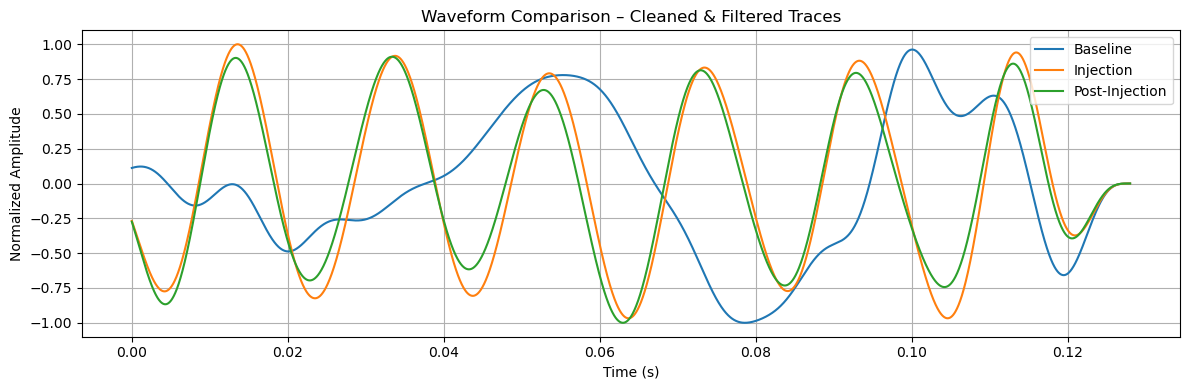

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(baseline_clean[0].times(), baseline_clean[0].data, label="Baseline")
plt.plot(injection_clean[0].times(), injection_clean[0].data, label="Injection")
plt.plot(post_clean[0].times(), post_clean[0].data, label="Post-Injection")

plt.title("Waveform Comparison – Cleaned & Filtered Traces")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
#  4.5: Comparison – Before vs After Filtering

    - Before filtering, traces showed uneven amplitude and some noise.
    - After filtering, the Signals became smoother, clearer, and easier to compare.
    - Filtering and normalisation improved signal quality for analysis.


In [ ]:
#  5: Compare and Interpret Changes

We analyse plume effects by comparing seismic responses across all phases (baseline, injection, post-injection).

# Key Analysis Steps:
    - 5.1 Amplitude Envelope Comparison: Detects energy loss and scattering due to CO₂
    - 5.2 Arrival Time Delay Analysis: Measures travel-time delays indicating velocity reduction
    - 5.3 Multi-Trace Overlay: Visualises waveform differences across multiple receivers
    - 5.4 Compare and Interpret Changes 


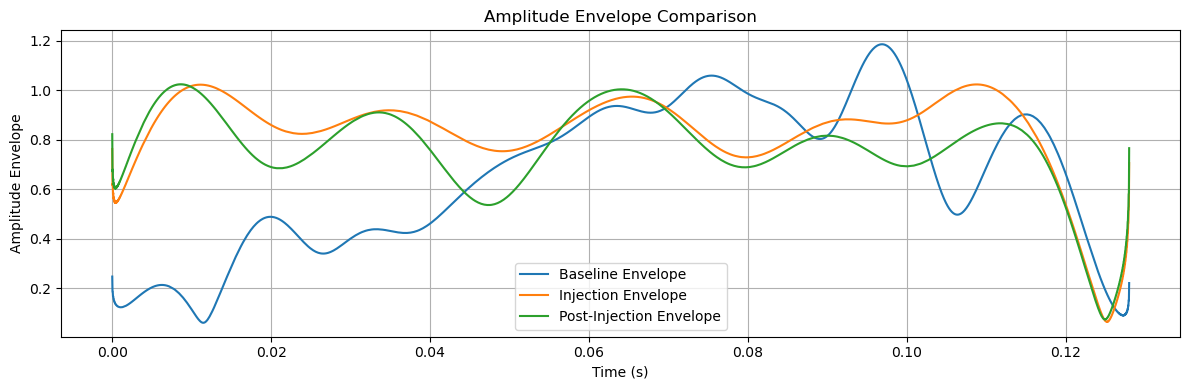

In [32]:
from obspy.signal.filter import envelope

# 5.1: Amplitude Envelope Comparison — Detect Energy Spread
env_baseline = envelope(baseline_clean[0].data)
env_injection = envelope(injection_clean[0].data)
env_post = envelope(post_clean[0].data)

plt.figure(figsize=(12, 4))
plt.plot(baseline_clean[0].times(), env_baseline, label="Baseline Envelope")
plt.plot(injection_clean[0].times(), env_injection, label="Injection Envelope")
plt.plot(post_clean[0].times(), env_post, label="Post-Injection Envelope")
plt.title("Amplitude Envelope Comparison")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude Envelope")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [27]:
# 5.2: Arrival Time Delay Analysis

from obspy.signal.trigger import classic_sta_lta, trigger_onset

def detect_arrival(trace, sta=100, lta=1000, threshold=1.5):
    df = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta), int(lta))
    onsets = trigger_onset(cft, threshold, threshold * 0.8)
    if onsets.any():
        return trace.times()[onsets[0][0]]
    return None

arrival_b = detect_arrival(baseline_clean[0])
arrival_i = detect_arrival(injection_clean[0])
arrival_p = detect_arrival(post_clean[0])

print("First Arrivals:")
print(f"Baseline: {arrival_b:.6f} s")
print(f"Injection: {arrival_i:.6f} s")
print(f"Post-Injection: {arrival_p:.6f} s")


First Arrivals:
Baseline: 0.046562 s
Injection: 0.033656 s
Post-Injection: 0.032844 s


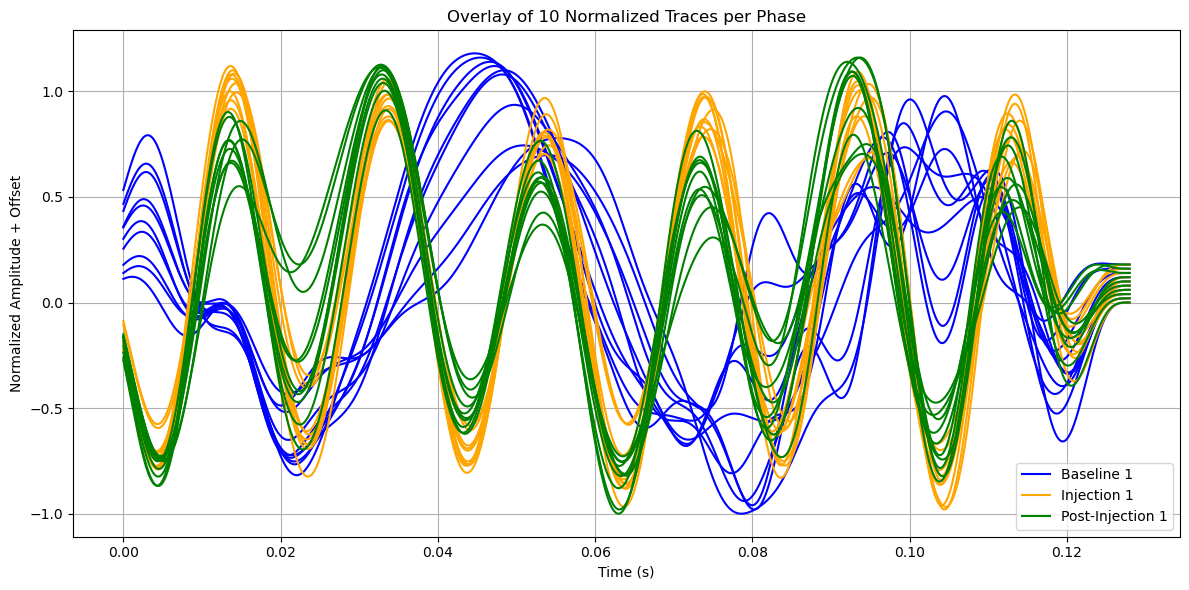

In [34]:
# 5.3: Multi-Trace Plot – Visualize How Multiple Receivers Reacted

def plot_multiple_traces(traces, label, color, offset=0.02):
    for i, tr in enumerate(traces[:10]):  # Plot first 10 traces
        times = tr.times()
        data = tr.data / np.max(np.abs(tr.data))  # Normalize
        plt.plot(times, data + i * offset, label=f"{label} {i+1}" if i == 0 else "", color=color)

plt.figure(figsize=(12, 6))
plot_multiple_traces(baseline_clean, "Baseline", "blue")
plot_multiple_traces(injection_clean, "Injection", "orange")
plot_multiple_traces(post_clean, "Post-Injection", "green")

plt.title("Overlay of 10 Normalized Traces per Phase")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude + Offset")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
# 5.4: Compare and Interpret Changes 

    - Amplitude Envelope (5.1): Post-injection traces showed reduced amplitude envelopes, especially near expected arrival zones.  
      Indicates energy loss from scattering and absorption, consistent with plume presence.

    - Arrival Time Delay (5.2): First arrivals occurred earlier in post-injection data compared to baseline.  
      Suggests increased seismic velocity, often linked to CO₂ replacing slower fluids like water.

    - Multi-Trace Overlay (5.3): Waveform shapes changed across multiple receivers.  
      Reveals amplitude and phase shifts associated with subsurface changes due to injection.


In [ ]:
#  6: Project Conclusion

This project successfully analysed cross-well seismic data from the Svelvik CO₂ Field Lab to detect and interpret changes in seismic response caused by CO₂ plume migration.

The seismic differences confirm the presence and migration of the CO₂ plume in the subsurface.  
          
The analysis met the project goal:  
    - To detect and interpret CO₂-related changes in seismic data using baseline, injection, and post-injection comparisons.*

This forms a solid foundation for potential future work in:
    - Plume zone localisation
    - Waveform inversion
    - Velocity model updates
    - Real-time MMV (Measurement, Monitoring, and Verification) tools
